In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [2]:
import os
os.getcwd()
os.chdir("C:\\Users\\Home\\Desktop\\Saptha\\Machine-Learning\\AmExpert")


In [3]:
# Invoke garbage collector in python
import gc 

In [4]:
# Importing input Datasets

train = pd.read_csv('train.csv')
campaign = pd.read_csv('campaign_data.csv')
couponItem = pd.read_csv('coupon_item_mapping.csv')
customerDem = pd.read_csv('customer_demographics.csv')
customerTrans = pd.read_csv('customer_transaction_data.csv')
item = pd.read_csv('item_data.csv')


In [5]:
# Combining train and customer demographics based on customer_id.
trainAnalysis = pysqldf("SELECT t.id, t.campaign_id, t.coupon_id, t.customer_id, t.redemption_status, c.age_range, c.marital_status, c.rented, c.family_size, c.no_of_children, c.income_bracket from train t LEFT JOIN customerDem c ON t.customer_id = c.customer_id;")
print (trainAnalysis.shape)
# (78369, 11)
print (train.shape)
print (customerDem.shape)
del train
gc.collect()

(78369, 11)
(78369, 5)
(760, 7)


197

In [6]:
trainAnalysis.id.nunique()
# So every row has unique id, so deleting id column has dosen't have any significance during model building.
del trainAnalysis['id']
gc.collect()

7

In [7]:
# Combining campaign data and the table formed by joining train,customer demographics based on campaign_id.
trainAnalysis = pysqldf("SELECT t.*, c.campaign_type, c.start_date, c.end_date from trainAnalysis t LEFT JOIN campaign c ON t.campaign_id = c.campaign_id;")
print (trainAnalysis.shape)

(78369, 13)


In [8]:
# Get the no. of items that be redeemed by the coupon.
couponItemCount = couponItem.groupby('coupon_id').count()
trainAnalysis = pysqldf("select t.*, c.item_id as itemCount from trainAnalysis t LEFT JOIN couponItemCount c on t.coupon_id = c.coupon_id")

In [9]:
# Combining couponItem & item tables based on item id.
couponItem_item = pysqldf("select c.coupon_id,i.* from couponItem c LEFT JOIN item i ON c.item_id = i.item_id;")

In [10]:
# Dummy encoding category and brand type
# We get the category & brand count of items for a specific coupon.

couponItem_item = pd.get_dummies(couponItem_item, columns=['brand_type'], prefix = ['brand'])
couponItem_item = pd.get_dummies(couponItem_item, columns=['category'], prefix = ['category'])
couponItem_item.rename(columns = {"category_Dairy, Juices & Snacks": "category_DairyJuices", "category_Flowers & Plants":"category_FlowersPlants", "category_Natural Products": "category_Natural_Products", "category_Packaged Meat": "category_Packaged_Meat", "category_Prepared Food" : "category_Prepared_Food", "category_Skin & Hair Care" : "category_Skin_Hair_Care", "category_Vegetables (cut)" : "category_Vegetables_cut"}, inplace = True)  
print (couponItem_item.columns)
couponitem_item_Group = pysqldf("select coupon_id,SUM(brand_Established),SUM(brand_Local),SUM(category_Bakery),SUM(category_DairyJuices),SUM(category_FlowersPlants),SUM(category_Garden),SUM(category_Grocery),SUM(category_Meat),SUM(category_Miscellaneous),SUM(category_Natural_Products),SUM(category_Packaged_Meat),SUM(category_Pharmaceutical),SUM(category_Prepared_Food),SUM(category_Restauarant),SUM(category_Salads),SUM(category_Seafood),SUM(category_Skin_Hair_Care),SUM(category_Travel),SUM(category_Vegetables_cut) from couponItem_item group by coupon_id;")
trainAnalysis = pysqldf("SELECT * from trainAnalysis t LEFT JOIN couponitem_item_Group c ON t.coupon_id = c.coupon_id;")

Index(['coupon_id', 'item_id', 'brand', 'brand_Established', 'brand_Local',
       'category_Bakery', 'category_DairyJuices', 'category_FlowersPlants',
       'category_Garden', 'category_Grocery', 'category_Meat',
       'category_Miscellaneous', 'category_Natural_Products',
       'category_Packaged_Meat', 'category_Pharmaceutical',
       'category_Prepared_Food', 'category_Restauarant', 'category_Salads',
       'category_Seafood', 'category_Skin_Hair_Care', 'category_Travel',
       'category_Vegetables_cut'],
      dtype='object')


In [11]:
# Generating new features from campaign dates in trainAnalysis.

trainAnalysis['NoOfDaysOfCampaign'] = pd.to_datetime(trainAnalysis['end_date'], format='%d/%m/%y') - pd.to_datetime(trainAnalysis['start_date'], format='%d/%m/%y')
trainAnalysis['NoOfDaysOfCampaign'] = trainAnalysis['NoOfDaysOfCampaign'].dt.days.astype('int16')

# The day of the week with Monday=0, Sunday=6.
trainAnalysis['dayOfWeekOfCamStart'] = pd.to_datetime(trainAnalysis['start_date'], format  = '%d/%m/%y').dt.dayofweek
trainAnalysis['dayOfWeekOfCamEnd'] = pd.to_datetime(trainAnalysis['end_date'], format  = '%d/%m/%y').dt.dayofweek

In [12]:
trainAnalysis['campaignStartMonth'] = pd.to_datetime(trainAnalysis['start_date'], format  = '%d/%m/%y').dt.month
trainAnalysis['campaignEndMonth'] = pd.to_datetime(trainAnalysis['end_date'], format  = '%d/%m/%y').dt.month

# Finding the quarters of the year that the campaign was active

q1 = [1,2,3,4]
q2 = [5,6,7,8]
q3 = [9,10,11,12]

trainAnalysis['Q1'] = 0
trainAnalysis['Q2'] = 0
trainAnalysis['Q3'] = 0

for index, rec in trainAnalysis.iterrows():
    camStMth = rec['campaignStartMonth']
    camEndMth = rec['campaignEndMonth'] + 1
    for mth in range(camStMth, camEndMth):
        if mth in q1:
            trainAnalysis.loc[index,'Q1'] = 1
        if mth in q2:
            trainAnalysis.loc[index,'Q2'] = 1
        if mth in q3:
            trainAnalysis.loc[index,'Q3'] = 1
            
trainAnalysis['campaignStartDayOfMonth'] = pd.to_datetime(trainAnalysis['start_date'], format  = '%d/%m/%y').dt.day
trainAnalysis['campaignEndDayOfMonth'] = pd.to_datetime(trainAnalysis['end_date'], format  = '%d/%m/%y').dt.day
del trainAnalysis['campaignStartMonth']
del trainAnalysis['campaignEndMonth']

In [13]:
# Calculating the no. of saturdays & sundays between campaign start & end dates(start & end day inclusive)

from datetime import  date
for index, rec in trainAnalysis.iterrows():
    sat = 0
    sun = 0
    date1 = pd.to_datetime(rec['start_date'], format  = '%d/%m/%y')
    date2 = pd.to_datetime(rec['end_date'], format  = '%d/%m/%y')
    date1_ord = date1.toordinal()
    date2_ord = date2.toordinal()
    for d_ord in range(date1_ord, date2_ord):
        d = date.fromordinal(d_ord)
        if (d.weekday() == 5):
            sat = sat + 1
        if (d.weekday() == 6):
            sun = sun + 1 
    # Since range dosen't consider the last value
    d = date.fromordinal(date2_ord)
    if (d.weekday() == 5):
        sat = sat + 1
    if (d.weekday() == 6):
        sun = sun + 1   
    trainAnalysis.loc[index,'NoOfSunInCam'] = sun
    trainAnalysis.loc[index,'NoOfSatInCam'] = sat

In [14]:
# Feature Engineering in Customer Transaction data.

CT = customerTrans.copy(deep = True)
CTItem = pysqldf("select * from CT c LEFT JOIN item i ON c.item_id = i.item_id")

CTItem['coupon_discount'] = abs(CTItem['coupon_discount'])
CTItem['couponDisc_availed'] = 0
CTItem.loc[(CTItem.coupon_discount > 0),'couponDisc_availed'] = 1 
CTItem = pysqldf("select * from CTItem order by customer_id;")
CTItem['couponDisc_availed_Ct'] = 0
CTItem['couponDisc_availed_Ct']  = pysqldf("SELECT SUM(couponDisc_availed) over (PARTITION BY customer_id order by date) from CTItem;")

CTItemGroup = pysqldf("select customer_id, date, max(couponDisc_availed_Ct) as couponDisc_availed_Ct from CTItem group by customer_id,date;")
trainAnalysis = pysqldf("select * from trainAnalysis ORDER BY customer_id,campaign_id;")

trainAnalysis['start_date'] = pd.to_datetime(trainAnalysis['start_date'], format  = '%d/%m/%y')
trainAnalysis['end_date'] = pd.to_datetime(trainAnalysis['end_date'], format  = '%d/%m/%y')
CTItemGroup['date'] = pd.to_datetime(CTItemGroup['date'], format  = '%Y-%m-%d')

track = pysqldf('select max(couponDisc_availed_Ct) as couponDisc_availed_Ct, trainAnalysis.customer_id, trainAnalysis.start_date, trainAnalysis.campaign_id from trainAnalysis LEFT JOIN CTItemGroup where trainAnalysis.customer_id = CTItemGroup.customer_id AND trainAnalysis.start_date > CTItemGroup.date GROUP BY trainAnalysis.customer_id,trainAnalysis.start_date ORDER BY trainAnalysis.customer_id, trainAnalysis.campaign_id;')
trainAnalysis['noItCouAvailUntilNow'] = pysqldf("select couponDisc_availed_Ct from track INNER JOIN trainAnalysis where track.customer_id = trainAnalysis.customer_id AND track.start_date = trainAnalysis.start_date ")

trainAnalysis['HasRedeemedBefore'] = 0
trainAnalysis.loc[(trainAnalysis.noItCouAvailUntilNow > 0),'HasRedeemedBefore'] = 1 

In [102]:
CTItem['couponDisc_availed_Sum'] = pysqldf("SELECT SUM(coupon_discount) over (PARTITION BY customer_id order by date) from CTItem;")
CTItemSum = pysqldf("select customer_id, date, max(couponDisc_availed_Sum) as couponDisc_availed_Sum from CTItem group by customer_id,date;")
CTItemSum['date'] = pd.to_datetime(CTItemSum['date'], format  = '%Y-%m-%d')
ItemSum = pysqldf('select max(couponDisc_availed_Sum) as couponDisc_availed_Sum, trainAnalysis.customer_id, trainAnalysis.start_date, trainAnalysis.campaign_id from trainAnalysis LEFT JOIN CTItemSum where trainAnalysis.customer_id = CTItemSum.customer_id AND trainAnalysis.start_date > CTItemSum.date GROUP BY trainAnalysis.customer_id,trainAnalysis.start_date ORDER BY trainAnalysis.customer_id, trainAnalysis.campaign_id;')
trainAnalysis['sumItCouAvailUntilNow'] = pysqldf("select couponDisc_availed_Sum from ItemSum INNER JOIN trainAnalysis where ItemSum.customer_id = trainAnalysis.customer_id AND ItemSum.start_date = trainAnalysis.start_date;")

In [117]:
CTItem = pd.get_dummies(CTItem, columns=['brand_type'], prefix = ['brand'])
CTItem = pd.get_dummies(CTItem, columns=['category'], prefix = ['category'])
CTItem.rename(columns = {"category_Dairy, Juices & Snacks": "category_DairyJuices", "category_Flowers & Plants":"category_FlowersPlants", "category_Natural Products": "category_Natural_Products", "category_Packaged Meat": "category_Packaged_Meat", "category_Prepared Food" : "category_Prepared_Food", "category_Skin & Hair Care" : "category_Skin_Hair_Care", "category_Vegetables (cut)" : "category_Vegetables_cut"}, inplace = True)  
print (CTItem.columns)

Index(['date', 'customer_id', 'item_id', 'quantity', 'selling_price',
       'other_discount', 'coupon_discount', 'brand', 'couponDisc_availed',
       'couponDisc_availed_Ct', 'couponDisc_availed_Sum', 'brand_Established',
       'brand_Local', 'category_Alcohol', 'category_Bakery',
       'category_DairyJuices', 'category_FlowersPlants', 'category_Fuel',
       'category_Garden', 'category_Grocery', 'category_Meat',
       'category_Miscellaneous', 'category_Natural_Products',
       'category_Packaged_Meat', 'category_Pharmaceutical',
       'category_Prepared_Food', 'category_Restauarant', 'category_Salads',
       'category_Seafood', 'category_Skin_Hair_Care', 'category_Travel',
       'category_Vegetables_cut'],
      dtype='object')


In [118]:
CTItem['couDiscAvaiBrEstSum'] = pysqldf("SELECT SUM(brand_Established) over (PARTITION BY customer_id order by date) from CTItem;")
CTItem['couDiscAvaiBrLcSum'] = pysqldf("SELECT SUM(brand_Local) over (PARTITION BY customer_id order by date) from CTItem;")
CTItem['couDiscAvaiCtAlSum'] = pysqldf("SELECT SUM(category_Alcohol) over (PARTITION BY customer_id order by date) from CTItem;")
CTItem['couDiscAvaiCtBkSum'] = pysqldf("SELECT SUM(category_Bakery) over (PARTITION BY customer_id order by date) from CTItem;")
CTItem['couDiscAvaiCtDjSum'] = pysqldf("SELECT SUM(category_DairyJuices) over (PARTITION BY customer_id order by date) from CTItem;")
CTItem['couDiscAvaiCtFpSum'] = pysqldf("SELECT SUM(category_FlowersPlants) over (PARTITION BY customer_id order by date) from CTItem;")
CTItem['couDiscAvaiCtFuSum'] = pysqldf("SELECT SUM(category_Fuel) over (PARTITION BY customer_id order by date) from CTItem;")
CTItem['couDiscAvaiCtGarSum'] = pysqldf("SELECT SUM(category_Garden) over (PARTITION BY customer_id order by date) from CTItem;")
CTItem['couDiscAvaiCtGroSum'] = pysqldf("SELECT SUM(category_Grocery) over (PARTITION BY customer_id order by date) from CTItem;")
CTItem['couDiscAvaiCtMtSum'] = pysqldf("SELECT SUM(category_Meat) over (PARTITION BY customer_id order by date) from CTItem;")
CTItem['couDiscAvaiCtMsSum'] = pysqldf("SELECT SUM(category_Miscellaneous) over (PARTITION BY customer_id order by date) from CTItem;")
CTItem['couDiscAvaiCtNpSum'] = pysqldf("SELECT SUM(category_Natural_Products) over (PARTITION BY customer_id order by date) from CTItem;")
CTItem['couDiscAvaiCtPmSum'] = pysqldf("SELECT SUM(category_Packaged_Meat) over (PARTITION BY customer_id order by date) from CTItem;")
CTItem['couDiscAvaiCtPharSum'] = pysqldf("SELECT SUM(category_Pharmaceutical) over (PARTITION BY customer_id order by date) from CTItem;")
CTItem['couDiscAvaiCtPfSum'] = pysqldf("SELECT SUM(category_Prepared_Food) over (PARTITION BY customer_id order by date) from CTItem;")
CTItem['couDiscAvaiCtResSum'] = pysqldf("SELECT SUM(category_Restauarant) over (PARTITION BY customer_id order by date) from CTItem;")
CTItem['couDiscAvaiCtSalSum'] = pysqldf("SELECT SUM(category_Salads) over (PARTITION BY customer_id order by date) from CTItem;")
CTItem['couDiscAvaiCtSfSum'] = pysqldf("SELECT SUM(category_Seafood) over (PARTITION BY customer_id order by date) from CTItem;")
CTItem['couDiscAvaiCtSkhSum'] = pysqldf("SELECT SUM(category_Skin_Hair_Care) over (PARTITION BY customer_id order by date) from CTItem;")
CTItem['couDiscAvaiCtTraSum'] = pysqldf("SELECT SUM(category_Travel) over (PARTITION BY customer_id order by date) from CTItem;")
CTItem['couDiscAvaiCtVcSum'] = pysqldf("SELECT SUM(category_Vegetables_cut) over (PARTITION BY customer_id order by date) from CTItem;")

In [124]:
CTItemType = pysqldf("select customer_id, date, max(couDiscAvaiBrEstSum) as couDiscAvaiBrEstSum,max(couDiscAvaiBrLcSum) as couDiscAvaiBrLcSum,max(couDiscAvaiCtAlSum) as couDiscAvaiCtAlSum,max(couDiscAvaiCtBkSum) as couDiscAvaiCtBkSum,max(couDiscAvaiCtDjSum) as couDiscAvaiCtDjSum,max(couDiscAvaiCtFpSum) as couDiscAvaiCtFpSum,max(couDiscAvaiCtFuSum) as couDiscAvaiCtFuSum,max(couDiscAvaiCtGarSum) as couDiscAvaiCtGarSum,max(couDiscAvaiCtGroSum) as couDiscAvaiCtGroSum,max(couDiscAvaiCtMtSum) as couDiscAvaiCtMtSum,max(couDiscAvaiCtMsSum) as couDiscAvaiCtMsSum,max(couDiscAvaiCtNpSum) as couDiscAvaiCtNpSum,max(couDiscAvaiCtPmSum) as couDiscAvaiCtPmSum,max(couDiscAvaiCtPharSum) as couDiscAvaiCtPharSum,max(couDiscAvaiCtPfSum) as couDiscAvaiCtPfSum,max(couDiscAvaiCtResSum) as couDiscAvaiCtResSum,max(couDiscAvaiCtSalSum) as couDiscAvaiCtSalSum,max(couDiscAvaiCtSfSum) as couDiscAvaiCtSfSum,max(couDiscAvaiCtSkhSum) as couDiscAvaiCtSkhSum,max(couDiscAvaiCtTraSum) as couDiscAvaiCtTraSum,max(couDiscAvaiCtVcSum) as couDiscAvaiCtVcSum from CTItem group by customer_id,date;")
CTItemType['date'] = pd.to_datetime(CTItemType['date'], format  = '%Y-%m-%d')

In [125]:
ItemType = pysqldf('select max(couDiscAvaiBrEstSum) as couDiscAvaiBrEstSum,max(couDiscAvaiBrLcSum) as couDiscAvaiBrLcSum,max(couDiscAvaiCtAlSum) as couDiscAvaiCtAlSum,max(couDiscAvaiCtBkSum) as couDiscAvaiCtBkSum,max(couDiscAvaiCtDjSum) as couDiscAvaiCtDjSum,max(couDiscAvaiCtFpSum) as couDiscAvaiCtFpSum,max(couDiscAvaiCtFuSum) as couDiscAvaiCtFuSum,max(couDiscAvaiCtGarSum) as couDiscAvaiCtGarSum,max(couDiscAvaiCtGroSum) as couDiscAvaiCtGroSum,max(couDiscAvaiCtMtSum) as couDiscAvaiCtMtSum,max(couDiscAvaiCtMsSum) as couDiscAvaiCtMsSum,max(couDiscAvaiCtNpSum) as couDiscAvaiCtNpSum,max(couDiscAvaiCtPmSum) as couDiscAvaiCtPmSum,max(couDiscAvaiCtPharSum) as couDiscAvaiCtPharSum,max(couDiscAvaiCtPfSum) as couDiscAvaiCtPfSum,max(couDiscAvaiCtResSum) as couDiscAvaiCtResSum,max(couDiscAvaiCtSalSum) as couDiscAvaiCtSalSum,max(couDiscAvaiCtSfSum) as couDiscAvaiCtSfSum,max(couDiscAvaiCtSkhSum) as couDiscAvaiCtSkhSum,max(couDiscAvaiCtTraSum) as couDiscAvaiCtTraSum,max(couDiscAvaiCtVcSum) as couDiscAvaiCtVcSum, trainAnalysis.customer_id, trainAnalysis.start_date, trainAnalysis.campaign_id from trainAnalysis LEFT JOIN CTItemType where trainAnalysis.customer_id = CTItemType.customer_id AND trainAnalysis.start_date > CTItemType.date GROUP BY trainAnalysis.customer_id,trainAnalysis.start_date ORDER BY trainAnalysis.customer_id, trainAnalysis.campaign_id;')
trainAnalysis['couDiscAvaiBrEstSum'] = pysqldf("select couDiscAvaiBrEstSum from ItemType INNER JOIN trainAnalysis where ItemType.customer_id = trainAnalysis.customer_id AND ItemType.start_date = trainAnalysis.start_date;")
trainAnalysis['couDiscAvaiBrLcSum'] = pysqldf("select couDiscAvaiBrLcSum from ItemType INNER JOIN trainAnalysis where ItemType.customer_id = trainAnalysis.customer_id AND ItemType.start_date = trainAnalysis.start_date;")
trainAnalysis['couDiscAvaiCtAlSum'] = pysqldf("select couDiscAvaiCtAlSum from ItemType INNER JOIN trainAnalysis where ItemType.customer_id = trainAnalysis.customer_id AND ItemType.start_date = trainAnalysis.start_date;")
trainAnalysis['couDiscAvaiCtBkSum'] = pysqldf("select couDiscAvaiCtBkSum from ItemType INNER JOIN trainAnalysis where ItemType.customer_id = trainAnalysis.customer_id AND ItemType.start_date = trainAnalysis.start_date;")
trainAnalysis['couDiscAvaiCtDjSum'] = pysqldf("select couDiscAvaiCtDjSum from ItemType INNER JOIN trainAnalysis where ItemType.customer_id = trainAnalysis.customer_id AND ItemType.start_date = trainAnalysis.start_date;")
trainAnalysis['couDiscAvaiCtFpSum'] = pysqldf("select couDiscAvaiCtFpSum from ItemType INNER JOIN trainAnalysis where ItemType.customer_id = trainAnalysis.customer_id AND ItemType.start_date = trainAnalysis.start_date;")
trainAnalysis['couDiscAvaiCtFuSum'] = pysqldf("select couDiscAvaiCtFuSum from ItemType INNER JOIN trainAnalysis where ItemType.customer_id = trainAnalysis.customer_id AND ItemType.start_date = trainAnalysis.start_date;")
trainAnalysis['couDiscAvaiCtGarSum'] = pysqldf("select couDiscAvaiCtGarSum from ItemType INNER JOIN trainAnalysis where ItemType.customer_id = trainAnalysis.customer_id AND ItemType.start_date = trainAnalysis.start_date;")
trainAnalysis['couDiscAvaiCtGroSum'] = pysqldf("select couDiscAvaiCtGroSum from ItemType INNER JOIN trainAnalysis where ItemType.customer_id = trainAnalysis.customer_id AND ItemType.start_date = trainAnalysis.start_date;")
trainAnalysis['couDiscAvaiCtMtSum'] = pysqldf("select couDiscAvaiCtMtSum from ItemType INNER JOIN trainAnalysis where ItemType.customer_id = trainAnalysis.customer_id AND ItemType.start_date = trainAnalysis.start_date;")
trainAnalysis['couDiscAvaiCtMsSum'] = pysqldf("select couDiscAvaiCtMsSum from ItemType INNER JOIN trainAnalysis where ItemType.customer_id = trainAnalysis.customer_id AND ItemType.start_date = trainAnalysis.start_date;")
trainAnalysis['couDiscAvaiCtNpSum'] = pysqldf("select couDiscAvaiCtNpSum from ItemType INNER JOIN trainAnalysis where ItemType.customer_id = trainAnalysis.customer_id AND ItemType.start_date = trainAnalysis.start_date;")
trainAnalysis['couDiscAvaiCtPmSum'] = pysqldf("select couDiscAvaiCtPmSum from ItemType INNER JOIN trainAnalysis where ItemType.customer_id = trainAnalysis.customer_id AND ItemType.start_date = trainAnalysis.start_date;")
trainAnalysis['couDiscAvaiCtPharSum'] = pysqldf("select couDiscAvaiCtPharSum from ItemType INNER JOIN trainAnalysis where ItemType.customer_id = trainAnalysis.customer_id AND ItemType.start_date = trainAnalysis.start_date;")
trainAnalysis['couDiscAvaiCtPfSum'] = pysqldf("select couDiscAvaiCtPfSum from ItemType INNER JOIN trainAnalysis where ItemType.customer_id = trainAnalysis.customer_id AND ItemType.start_date = trainAnalysis.start_date;")
trainAnalysis['couDiscAvaiCtResSum'] = pysqldf("select couDiscAvaiCtResSum from ItemType INNER JOIN trainAnalysis where ItemType.customer_id = trainAnalysis.customer_id AND ItemType.start_date = trainAnalysis.start_date;")
trainAnalysis['couDiscAvaiCtSalSum'] = pysqldf("select couDiscAvaiCtSalSum from ItemType INNER JOIN trainAnalysis where ItemType.customer_id = trainAnalysis.customer_id AND ItemType.start_date = trainAnalysis.start_date;")
trainAnalysis['couDiscAvaiCtSfSum'] = pysqldf("select couDiscAvaiCtSfSum from ItemType INNER JOIN trainAnalysis where ItemType.customer_id = trainAnalysis.customer_id AND ItemType.start_date = trainAnalysis.start_date;")
trainAnalysis['couDiscAvaiCtSkhSum'] = pysqldf("select couDiscAvaiCtSkhSum from ItemType INNER JOIN trainAnalysis where ItemType.customer_id = trainAnalysis.customer_id AND ItemType.start_date = trainAnalysis.start_date;")
trainAnalysis['couDiscAvaiCtTraSum'] = pysqldf("select couDiscAvaiCtTraSum from ItemType INNER JOIN trainAnalysis where ItemType.customer_id = trainAnalysis.customer_id AND ItemType.start_date = trainAnalysis.start_date;")
trainAnalysis['couDiscAvaiCtVcSum'] = pysqldf("select couDiscAvaiCtVcSum from ItemType INNER JOIN trainAnalysis where ItemType.customer_id = trainAnalysis.customer_id AND ItemType.start_date = trainAnalysis.start_date;")

In [23]:
######################## Performing all the transformation to test data as well ########################

test = pd.read_csv('test.csv')

testAnalysis = pysqldf("SELECT t.id, t.campaign_id, t.coupon_id, t.customer_id, c.age_range, c.marital_status, c.rented, c.family_size, c.no_of_children, c.income_bracket from test t LEFT JOIN customerDem c ON t.customer_id = c.customer_id;")
testAnalysis = pysqldf("SELECT t.*, c.campaign_type, c.start_date, c.end_date from testAnalysis t LEFT JOIN campaign c ON t.campaign_id = c.campaign_id;")
testAnalysis = pysqldf("select t.*, c.item_id as itemCount from testAnalysis t LEFT JOIN couponItemCount c on t.coupon_id = c.coupon_id")
testAnalysis = pysqldf("SELECT * from testAnalysis t LEFT JOIN couponitem_item_Group c ON t.coupon_id = c.coupon_id;")
testAnalysis['NoOfDaysOfCampaign'] = pd.to_datetime(testAnalysis['end_date'], format='%d/%m/%y') - pd.to_datetime(testAnalysis['start_date'], format='%d/%m/%y')
testAnalysis['NoOfDaysOfCampaign'] = testAnalysis['NoOfDaysOfCampaign'].dt.days.astype('int16')
testAnalysis['dayOfWeekOfCamStart'] = pd.to_datetime(testAnalysis['start_date'], format  = '%d/%m/%y').dt.dayofweek
testAnalysis['dayOfWeekOfCamEnd'] = pd.to_datetime(testAnalysis['end_date'], format  = '%d/%m/%y').dt.dayofweek

testAnalysis['campaignStartMonth'] = pd.to_datetime(testAnalysis['start_date'], format  = '%d/%m/%y').dt.month
testAnalysis['campaignEndMonth'] = pd.to_datetime(testAnalysis['end_date'], format  = '%d/%m/%y').dt.month

print ("************* Done *************")

# Finding the quarters of the year that the campaign was active

q1 = [1,2,3,4]
q2 = [5,6,7,8]
q3 = [9,10,11,12]

testAnalysis['Q1'] = 0
testAnalysis['Q2'] = 0
testAnalysis['Q3'] = 0

for index, rec in testAnalysis.iterrows():
    camStMth = rec['campaignStartMonth']
    camEndMth = rec['campaignEndMonth'] + 1
    for mth in range(camStMth, camEndMth):
        if mth in q1:
            testAnalysis.loc[index,'Q1'] = 1
        if mth in q2:
            testAnalysis.loc[index,'Q2'] = 1
        if mth in q3:
            testAnalysis.loc[index,'Q3'] = 1
            
testAnalysis['campaignStartDayOfMonth'] = pd.to_datetime(testAnalysis['start_date'], format  = '%d/%m/%y').dt.day
testAnalysis['campaignEndDayOfMonth'] = pd.to_datetime(testAnalysis['end_date'], format  = '%d/%m/%y').dt.day
del testAnalysis['campaignStartMonth']
del testAnalysis['campaignEndMonth']

print ("************* Done *************")

# Calculating the no. of saturdays & sundays between campaign start & end dates(start & end day inclusive)

from datetime import  date
for index, rec in testAnalysis.iterrows():
    sat = 0
    sun = 0
    date1 = pd.to_datetime(rec['start_date'], format  = '%d/%m/%y')
    date2 = pd.to_datetime(rec['end_date'], format  = '%d/%m/%y')
    date1_ord = date1.toordinal()
    date2_ord = date2.toordinal()
    for d_ord in range(date1_ord, date2_ord):
        d = date.fromordinal(d_ord)
        if (d.weekday() == 5):
            sat = sat + 1
        if (d.weekday() == 6):
            sun = sun + 1 
    # Since range dosen't consider the last value
    d = date.fromordinal(date2_ord)
    if (d.weekday() == 5):
        sat = sat + 1
    if (d.weekday() == 6):
        sun = sun + 1   
    testAnalysis.loc[index,'NoOfSunInCam'] = sun
    testAnalysis.loc[index,'NoOfSatInCam'] = sat
    
print ("************* Done *************")

testAnalysis = pysqldf("select * from testAnalysis ORDER BY customer_id,campaign_id;")

testAnalysis['start_date'] = pd.to_datetime(testAnalysis['start_date'], format  = '%d/%m/%y')
testAnalysis['end_date'] = pd.to_datetime(testAnalysis['end_date'], format  = '%d/%m/%y')

trackTest = pysqldf('select max(couponDisc_availed_Ct) as couponDisc_availed_Ct, testAnalysis.customer_id, testAnalysis.start_date, testAnalysis.campaign_id from testAnalysis LEFT JOIN CTItemGroup where testAnalysis.customer_id = CTItemGroup.customer_id AND testAnalysis.start_date > CTItemGroup.date GROUP BY testAnalysis.customer_id,testAnalysis.start_date ORDER BY testAnalysis.customer_id, testAnalysis.campaign_id;')
testAnalysis['noItCouAvailUntilNow'] = pysqldf("select couponDisc_availed_Ct from trackTest INNER JOIN testAnalysis where trackTest.customer_id = testAnalysis.customer_id AND trackTest.start_date = testAnalysis.start_date ")

testAnalysis['HasRedeemedBefore'] = 0
testAnalysis.loc[(testAnalysis.noItCouAvailUntilNow > 0),'HasRedeemedBefore'] = 1 

print ("************* Done *************")

ItemSumTest = pysqldf('select max(couponDisc_availed_Sum) as couponDisc_availed_Sum, testAnalysis.customer_id, testAnalysis.start_date, testAnalysis.campaign_id from testAnalysis LEFT JOIN CTItemSum where testAnalysis.customer_id = CTItemSum.customer_id AND testAnalysis.start_date > CTItemSum.date GROUP BY testAnalysis.customer_id,testAnalysis.start_date ORDER BY testAnalysis.customer_id, testAnalysis.campaign_id;')
testAnalysis['sumItCouAvailUntilNow'] = pysqldf("select couponDisc_availed_Sum from ItemSumTest INNER JOIN testAnalysis where ItemSumTest.customer_id = testAnalysis.customer_id AND ItemSumTest.start_date = testAnalysis.start_date;")

print ("************* Done *************")

ItemTypeTest = pysqldf('select max(couDiscAvaiBrEstSum) as couDiscAvaiBrEstSum,max(couDiscAvaiBrLcSum) as couDiscAvaiBrLcSum,max(couDiscAvaiCtAlSum) as couDiscAvaiCtAlSum,max(couDiscAvaiCtBkSum) as couDiscAvaiCtBkSum,max(couDiscAvaiCtDjSum) as couDiscAvaiCtDjSum,max(couDiscAvaiCtFpSum) as couDiscAvaiCtFpSum,max(couDiscAvaiCtFuSum) as couDiscAvaiCtFuSum,max(couDiscAvaiCtGarSum) as couDiscAvaiCtGarSum,max(couDiscAvaiCtGroSum) as couDiscAvaiCtGroSum,max(couDiscAvaiCtMtSum) as couDiscAvaiCtMtSum,max(couDiscAvaiCtMsSum) as couDiscAvaiCtMsSum,max(couDiscAvaiCtNpSum) as couDiscAvaiCtNpSum,max(couDiscAvaiCtPmSum) as couDiscAvaiCtPmSum,max(couDiscAvaiCtPharSum) as couDiscAvaiCtPharSum,max(couDiscAvaiCtPfSum) as couDiscAvaiCtPfSum,max(couDiscAvaiCtResSum) as couDiscAvaiCtResSum,max(couDiscAvaiCtSalSum) as couDiscAvaiCtSalSum,max(couDiscAvaiCtSfSum) as couDiscAvaiCtSfSum,max(couDiscAvaiCtSkhSum) as couDiscAvaiCtSkhSum,max(couDiscAvaiCtTraSum) as couDiscAvaiCtTraSum,max(couDiscAvaiCtVcSum) as couDiscAvaiCtVcSum, testAnalysis.customer_id, testAnalysis.start_date, testAnalysis.campaign_id from testAnalysis LEFT JOIN CTItemType where testAnalysis.customer_id = CTItemType.customer_id AND testAnalysis.start_date > CTItemType.date GROUP BY testAnalysis.customer_id,testAnalysis.start_date ORDER BY testAnalysis.customer_id, testAnalysis.campaign_id;')
testAnalysis['couDiscAvaiBrEstSum'] = pysqldf("select couDiscAvaiBrEstSum from ItemTypeTest INNER JOIN testAnalysis where ItemTypeTest.customer_id = testAnalysis.customer_id AND ItemTypeTest.start_date = testAnalysis.start_date;")
testAnalysis['couDiscAvaiBrLcSum'] = pysqldf("select couDiscAvaiBrLcSum from ItemTypeTest INNER JOIN testAnalysis where ItemTypeTest.customer_id = testAnalysis.customer_id AND ItemTypeTest.start_date = testAnalysis.start_date;")
testAnalysis['couDiscAvaiCtAlSum'] = pysqldf("select couDiscAvaiCtAlSum from ItemTypeTest INNER JOIN testAnalysis where ItemTypeTest.customer_id = testAnalysis.customer_id AND ItemTypeTest.start_date = testAnalysis.start_date;")
testAnalysis['couDiscAvaiCtBkSum'] = pysqldf("select couDiscAvaiCtBkSum from ItemTypeTest INNER JOIN testAnalysis where ItemTypeTest.customer_id = testAnalysis.customer_id AND ItemTypeTest.start_date = testAnalysis.start_date;")
testAnalysis['couDiscAvaiCtDjSum'] = pysqldf("select couDiscAvaiCtDjSum from ItemTypeTest INNER JOIN testAnalysis where ItemTypeTest.customer_id = testAnalysis.customer_id AND ItemTypeTest.start_date = testAnalysis.start_date;")
testAnalysis['couDiscAvaiCtFpSum'] = pysqldf("select couDiscAvaiCtFpSum from ItemTypeTest INNER JOIN testAnalysis where ItemTypeTest.customer_id = testAnalysis.customer_id AND ItemTypeTest.start_date = testAnalysis.start_date;")
testAnalysis['couDiscAvaiCtFuSum'] = pysqldf("select couDiscAvaiCtFuSum from ItemTypeTest INNER JOIN testAnalysis where ItemTypeTest.customer_id = testAnalysis.customer_id AND ItemTypeTest.start_date = testAnalysis.start_date;")
testAnalysis['couDiscAvaiCtGarSum'] = pysqldf("select couDiscAvaiCtGarSum from ItemTypeTest INNER JOIN testAnalysis where ItemTypeTest.customer_id = testAnalysis.customer_id AND ItemTypeTest.start_date = testAnalysis.start_date;")
testAnalysis['couDiscAvaiCtGroSum'] = pysqldf("select couDiscAvaiCtGroSum from ItemTypeTest INNER JOIN testAnalysis where ItemTypeTest.customer_id = testAnalysis.customer_id AND ItemTypeTest.start_date = testAnalysis.start_date;")
testAnalysis['couDiscAvaiCtMtSum'] = pysqldf("select couDiscAvaiCtMtSum from ItemTypeTest INNER JOIN testAnalysis where ItemTypeTest.customer_id = testAnalysis.customer_id AND ItemTypeTest.start_date = testAnalysis.start_date;")
testAnalysis['couDiscAvaiCtMsSum'] = pysqldf("select couDiscAvaiCtMsSum from ItemTypeTest INNER JOIN testAnalysis where ItemTypeTest.customer_id = testAnalysis.customer_id AND ItemTypeTest.start_date = testAnalysis.start_date;")
testAnalysis['couDiscAvaiCtNpSum'] = pysqldf("select couDiscAvaiCtNpSum from ItemTypeTest INNER JOIN testAnalysis where ItemTypeTest.customer_id = testAnalysis.customer_id AND ItemTypeTest.start_date = testAnalysis.start_date;")
testAnalysis['couDiscAvaiCtPmSum'] = pysqldf("select couDiscAvaiCtPmSum from ItemTypeTest INNER JOIN testAnalysis where ItemTypeTest.customer_id = testAnalysis.customer_id AND ItemTypeTest.start_date = testAnalysis.start_date;")
testAnalysis['couDiscAvaiCtPharSum'] = pysqldf("select couDiscAvaiCtPharSum from ItemTypeTest INNER JOIN testAnalysis where ItemTypeTest.customer_id = testAnalysis.customer_id AND ItemTypeTest.start_date = testAnalysis.start_date;")
testAnalysis['couDiscAvaiCtPfSum'] = pysqldf("select couDiscAvaiCtPfSum from ItemTypeTest INNER JOIN testAnalysis where ItemTypeTest.customer_id = testAnalysis.customer_id AND ItemTypeTest.start_date = testAnalysis.start_date;")
testAnalysis['couDiscAvaiCtResSum'] = pysqldf("select couDiscAvaiCtResSum from ItemTypeTest INNER JOIN testAnalysis where ItemTypeTest.customer_id = testAnalysis.customer_id AND ItemTypeTest.start_date = testAnalysis.start_date;")
testAnalysis['couDiscAvaiCtSalSum'] = pysqldf("select couDiscAvaiCtSalSum from ItemTypeTest INNER JOIN testAnalysis where ItemTypeTest.customer_id = testAnalysis.customer_id AND ItemTypeTest.start_date = testAnalysis.start_date;")
testAnalysis['couDiscAvaiCtSfSum'] = pysqldf("select couDiscAvaiCtSfSum from ItemTypeTest INNER JOIN testAnalysis where ItemTypeTest.customer_id = testAnalysis.customer_id AND ItemTypeTest.start_date = testAnalysis.start_date;")
testAnalysis['couDiscAvaiCtSkhSum'] = pysqldf("select couDiscAvaiCtSkhSum from ItemTypeTest INNER JOIN testAnalysis where ItemTypeTest.customer_id = testAnalysis.customer_id AND ItemTypeTest.start_date = testAnalysis.start_date;")
testAnalysis['couDiscAvaiCtTraSum'] = pysqldf("select couDiscAvaiCtTraSum from ItemTypeTest INNER JOIN testAnalysis where ItemTypeTest.customer_id = testAnalysis.customer_id AND ItemTypeTest.start_date = testAnalysis.start_date;")
testAnalysis['couDiscAvaiCtVcSum'] = pysqldf("select couDiscAvaiCtVcSum from ItemTypeTest INNER JOIN testAnalysis where ItemTypeTest.customer_id = testAnalysis.customer_id AND ItemTypeTest.start_date = testAnalysis.start_date;")

print ("************* Done *************")

gc.collect()

************* Done *************
************* Done *************
************* Done *************
************* Done *************


869

In [ ]:
#################### Logistic Regression ####################

In [ ]:
#################### Data Preparation for modelling using Logistic Regression ####################

In [220]:
logTrain = trainAnalysis.copy(deep = True) # Deep copy so that changes in logTrain are not reflected in trainAnalysis
logTest = testAnalysis.copy(deep = True)

In [221]:
# Deleting columns which are not meaningful for model building.
del logTrain['campaign_id']
del logTrain['coupon_id']
del logTrain['customer_id']
del logTrain['start_date']
del logTrain['end_date']

# Deleting columns which have more than 70% NaNs.
del logTrain['marital_status']
del logTrain['no_of_children']

gc.collect()
logTrain.head()

# Dummy encoding remaining categorical features
logTrain = pd.get_dummies(logTrain, columns=['campaign_type'], prefix = ['ct'])

logTrain.replace({'age_range':{np.nan :-999}}, inplace=True)
logTrain = pd.get_dummies(logTrain, columns=['age_range'], prefix = ['ar'])

logTrain.replace({'income_bracket':{np.nan :-999}}, inplace=True)
logTrain = pd.get_dummies(logTrain, columns=['income_bracket'], prefix = ['ib'])

logTrain.replace({'rented':{np.nan :-999}}, inplace=True)
logTrain = pd.get_dummies(logTrain, columns=['rented'], prefix = ['rt'])

logTrain.replace({'family_size':{np.nan :-999}}, inplace=True)
logTrain = pd.get_dummies(logTrain, columns=['family_size'], prefix = ['fs'])

In [222]:
####################### Making transformations for test data #######################

# Deleting columns which are not meaningful for model building.
del logTest['campaign_id']
del logTest['coupon_id']
del logTest['customer_id']
del logTest['start_date']
del logTest['end_date']

# Deleting columns which have more than 70% NaNs.
del logTest['marital_status']
del logTest['no_of_children']

gc.collect()
logTest.head()

# Dummy encoding remaining categorical features
logTest = pd.get_dummies(logTest, columns=['campaign_type'], prefix = ['ct'])

logTest.replace({'age_range':{np.nan :-999}}, inplace=True)
logTest = pd.get_dummies(logTest, columns=['age_range'], prefix = ['ar'])

logTest.replace({'income_bracket':{np.nan :-999}}, inplace=True)
logTest = pd.get_dummies(logTest, columns=['income_bracket'], prefix = ['ib'])

logTest.replace({'rented':{np.nan :-999}}, inplace=True)
logTest = pd.get_dummies(logTest, columns=['rented'], prefix = ['rt'])

logTest.replace({'family_size':{np.nan :-999}}, inplace=True)
logTest = pd.get_dummies(logTest, columns=['family_size'], prefix = ['fs'])

In [211]:
# Logistic Regression model fitting.
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


Y = logTrain['redemption_status']
del logTrain['redemption_status']
X = logTrain

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
print ('Model Coefficients')
print (logreg.coef_)

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print (roc_auc)
print (false_positive_rate)
print (true_positive_rate)

# Since the target class is highly skewed, we are applying over sampling and undersampling techniques.
# Applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
from imblearn.over_sampling import SMOTE
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier after SMOTE on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
print ('Model Coefficients')
print (logreg.coef_)

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print (roc_auc)
print (false_positive_rate)
print (true_positive_rate)

# Applying NearMiss
from imblearn.under_sampling import NearMiss
nr = NearMiss()
X_train, y_train = nr.fit_sample(X_train, y_train)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier after NearMiss on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
print ('Model Coefficients')
print (logreg.coef_)

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print (roc_auc)
print (false_positive_rate)
print (true_positive_rate)


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Home\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy of logistic regression classifier on test set: 0.99
[[23277     4]
 [  224     6]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     23281
           1       0.60      0.03      0.05       230

    accuracy                           0.99     23511
   macro avg       0.80      0.51      0.52     23511
weighted avg       0.99      0.99      0.99     23511

Model Coefficients
[[-4.17506626e-02  2.66658234e-03 -4.44172450e-02 -6.66101166e-02
  -9.22753187e-02 -5.43107438e-02 -6.85472993e-03  5.80917818e-02
   2.50904384e-02 -1.27941235e-01  8.91677849e-02  6.90729326e-02
   3.39462184e-02 -1.03990922e-01 -5.61544467e-04 -3.48535979e-04
   5.10882278e-02  8.61137782e-02 -9.53116133e-04 -4.75562247e-04
  -1.00089463e-01  1.40991794e-01 -4.06865685e-01 -2.75507527e-01
  -4.72947488e-02  1.14447938e-01 -1.67726340e-03 -6.27818429e-02
   6.39668594e-02  2.75277915e-02  1.57427253e-02  2.31360342e-01
  -1.38968841e-04 -7.61167598e-03 

C:\Users\Home\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of logistic regression classifier after SMOTE on test set: 0.81
[[18779  4502]
 [   73   157]]
              precision    recall  f1-score   support

           0       1.00      0.81      0.89     23281
           1       0.03      0.68      0.06       230

    accuracy                           0.81     23511
   macro avg       0.51      0.74      0.48     23511
weighted avg       0.99      0.81      0.88     23511

0.7446160612404591
[0.         0.19337657 1.        ]
[0.        0.6826087 1.       ]


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of logistic regression classifier after NearMiss on test set: 0.80
[[18768  4513]
 [   73   157]]
              precision    recall  f1-score   support

           0       1.00      0.81      0.89     23281
           1       0.03      0.68      0.06       230

    accuracy                           0.80     23511
   macro avg       0.51      0.74      0.48     23511
weighted avg       0.99      0.80      0.88     23511

0.7443798170928709
[0.         0.19384906 1.        ]
[0.        0.6826087 1.       ]


In [159]:
# Actual model building for submission

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

Y = logTrain['redemption_status']
del logTrain['redemption_status']
X = logTrain
test_id = logTest['id']
del logTest['id']
X_test = logTest

from imblearn.over_sampling import SMOTE
smt = SMOTE()
x_train, y_train = smt.fit_sample(X, Y)

logreg = LogisticRegression()
logreg.fit(x_train, y_train)
redemption_status = logreg.predict(X_test)
logTest['redemption_status'] = redemption_status
logTest['id'] = test_id
logTest.to_csv('submission16.csv')


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [175]:
del logTrain
del logTest
gc.collect()

14

In [160]:
# Lets go for random forest model building.
trainRf = trainAnalysis.copy(deep = True) 
testRf = testAnalysis.copy(deep = True)

In [161]:
#Lets Analyze Categorical features, before encoding it.

print (trainRf[['age_range', 'redemption_status']].groupby(['age_range'], as_index=False).mean().sort_values(by='redemption_status', ascending=False))
print (trainRf[['rented', 'redemption_status']].groupby(['rented'], as_index=False).mean().sort_values(by='redemption_status', ascending=False))
print (trainRf[['marital_status', 'redemption_status']].groupby(['marital_status'], as_index=False).mean().sort_values(by='redemption_status', ascending=False))
print (trainRf[['family_size', 'redemption_status']].groupby(['family_size'], as_index=False).mean().sort_values(by='redemption_status', ascending=False))
print (trainRf[['no_of_children', 'redemption_status']].groupby(['no_of_children'], as_index=False).mean().sort_values(by='redemption_status', ascending=False))
print (trainRf[['income_bracket', 'redemption_status']].groupby(['income_bracket'], as_index=False).mean().sort_values(by='redemption_status', ascending=False))
print (trainRf[['campaign_type', 'redemption_status']].groupby(['campaign_type'], as_index=False).mean().sort_values(by='redemption_status', ascending=False))

  age_range  redemption_status
3     46-55           0.014452
1     26-35           0.013584
2     36-45           0.013292
4     56-70           0.013161
5       70+           0.008727
0     18-25           0.006107
   rented  redemption_status
0     0.0           0.013097
1     1.0           0.011577
  marital_status  redemption_status
0        Married           0.014885
1         Single           0.011849
  family_size  redemption_status
3           4           0.019433
4          5+           0.015446
1           2           0.012849
0           1           0.012489
2           3           0.009893
  no_of_children  redemption_status
1              2           0.016634
2             3+           0.015873
0              1           0.012232
    income_bracket  redemption_status
5              6.0           0.020185
4              5.0           0.019752
9             10.0           0.015595
8              9.0           0.015354
0              1.0           0.010417
7              8.0

In [162]:
# Marital status - Dosent affect target, many Nas, so ignore it
# No of children - Dosent affect target, many Nas, so ignore it

del trainRf['marital_status']
del trainRf['no_of_children']

# Mean Encoding remaining categorical features.

ct_mean_encode = trainRf.groupby('campaign_type')['redemption_status'].mean()
trainRf.loc[:,'campaign_type'] = trainRf['campaign_type'].map(ct_mean_encode)

trainRf.replace({'income_bracket':{np.nan :-999}}, inplace=True)
ib_mean_encode = trainRf.groupby('income_bracket')['redemption_status'].mean()
trainRf.loc[:,'income_bracket'] = trainRf['income_bracket'].map(ib_mean_encode)

trainRf.replace({'rented':{np.nan :-999}}, inplace=True)
rt_mean_encode = trainRf.groupby('rented')['redemption_status'].mean()
trainRf.loc[:,'rented'] = trainRf['rented'].map(rt_mean_encode)

trainRf.replace({'age_range':{np.nan :-999}}, inplace=True)
ag_mean_encode = trainRf.groupby('age_range')['redemption_status'].mean()
trainRf.loc[:,'age_range'] = trainRf['age_range'].map(ag_mean_encode)

trainRf.replace({'family_size':{np.nan :-999}}, inplace=True)
fs_mean_encode = trainRf.groupby('family_size')['redemption_status'].mean()
trainRf.loc[:,'family_size'] = trainRf['family_size'].map(fs_mean_encode)

del trainRf['campaign_id']
del trainRf['coupon_id']
del trainRf['customer_id']
del trainRf['start_date']
del trainRf['end_date']


In [163]:
# Doing everything for test data:

del testRf['marital_status']
del testRf['no_of_children']

testRf.loc[:,'campaign_type'] = testRf['campaign_type'].map(ct_mean_encode)

testRf.replace({'income_bracket':{np.nan :-999}}, inplace=True)
testRf.loc[:,'income_bracket'] = testRf['income_bracket'].map(ib_mean_encode)

testRf.replace({'rented':{np.nan :-999}}, inplace=True)
testRf.loc[:,'rented'] = testRf['rented'].map(rt_mean_encode)

testRf.replace({'age_range':{np.nan :-999}}, inplace=True)
testRf.loc[:,'age_range'] = testRf['age_range'].map(ag_mean_encode)

testRf.replace({'family_size':{np.nan :-999}}, inplace=True)
testRf.loc[:,'family_size'] = testRf['family_size'].map(fs_mean_encode)

del testRf['campaign_id']
del testRf['coupon_id']
del testRf['customer_id']
del testRf['start_date']
del testRf['end_date']


In [138]:
# Random Forest model fitting.
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

Y = trainRf['redemption_status']
del trainRf['redemption_status']
X = trainRf

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
# Since SMOTE is good for our data over NearMiss, we go for it.
from imblearn.over_sampling import SMOTE
smt = SMOTE()
x_train, y_train = smt.fit_sample(x_train, y_train)

rf = RandomForestClassifier()
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print (roc_auc)
print (false_positive_rate)
print (true_positive_rate)

C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.5855223423467169
[0.         0.00721618 1.        ]
[0.         0.17826087 1.        ]


********** Train **********
1
0.9944903327875789
Test
0.6091871894043099
********** Train **********
2
0.9958056623558197
Test
0.5707344858561656
********** Train **********
4
0.9983075479681378
Test
0.5837564873763452
********** Train **********
8
0.9990341985687744
Test
0.5940891340764908
********** Train **********
16
0.9994573115767398
Test
0.5985872973482761
********** Train **********
32
0.9996688680807226
Test
0.5963489540827284
********** Train **********
64
0.9997884434960173
Test
0.5963704308234182
********** Train **********
100
0.9998160378226236
Test
0.5984369601634473
********** Train **********
200
0.9998160378226236
Test
0.5963274773420386


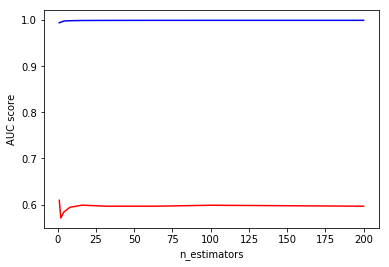

In [139]:
# Tuning Random forest parameters

n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(x_train, y_train)
    train_pred = rf.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print ("********** Train **********")
    print (estimator)
    print (roc_auc)
    train_results.append(roc_auc)
    y_pred = rf.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print ("Test")
    print (roc_auc)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1 = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2 = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
1.0
0.799968726429846
Test
0.7492811828268247


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
2.0
0.8338821538291726
Test
0.7482956805605616


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
3.0
0.8722934564653507
Test
0.7513431366873153


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
4.0
0.8817399142736254
Test
0.7597238277901555


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
5.0
0.9055630162438602
Test
0.7498828116975403


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
6.0
0.9238212623484611
Test
0.7548176998223967


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
7.0
0.9388417741312386
Test
0.7455278889484428


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
8.0
0.9514799757169925
Test
0.7364576077151922


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
9.0
0.9600066226383855
Test
0.7457021306794306


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
10.0
0.972516050699976
Test
0.7215600330928561


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
11.0
0.9784580290292316
Test
0.7174174499451875


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
12.0
0.9800309056457992
Test
0.725683567305304


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
13.0
0.9849794882172225
Test
0.7029636968380635


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
14.0
0.9858349123420225
Test
0.7038657199470365


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
15.0
0.9896061369782374
Test
0.6856702517260763


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
16.0
0.9914549568608693
Test
0.6693742611534317


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
17.0
0.9925863242517339
Test
0.65789858496292


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
18.0
0.9934877389208778
Test
0.6350164250377711


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
19.0
0.9949042476866756
Test
0.6491766938145119


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
20.0
0.9954285398921981
Test
0.627738237749387


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
21.0
0.996587501609669
Test
0.6184149978616638


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
22.0
0.9964587280855056
Test
0.6226769169858608


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
23.0
0.9964587280855055
Test
0.6224191960975829


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
24.0
0.9977096708916646
Test
0.6128597120622714


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
25.0
0.9980959914641548
Test
0.5977711812020625


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
26.0
0.9978660387424344
Test
0.5997088500979526


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
27.0
0.9975257087142885
Test
0.6150336251057497


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
28.0
0.9981603782262368
Test
0.602505588621436


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
29.0
0.9985283025809893
Test
0.5959194192689318


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
30.0
0.998546698798727
Test
0.5938743666695925


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
31.0
0.9988042458470539
Test
0.596391907564108


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
32.0
0.9988870288268732
Test
0.5964133843047978


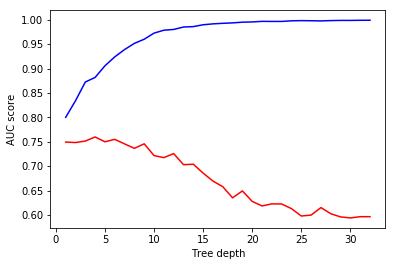

In [140]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
    rf.fit(x_train, y_train)
    train_pred = rf.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print ("********** Train **********")
    print (max_depth)
    print (roc_auc)
    train_results.append(roc_auc)
    y_pred = rf.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print ("Test")
    print (roc_auc)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
0.1
0.8705826082157508
Test
0.7014220403650673


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
0.2
0.8701962876432605
Test
0.7087837068107413


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
0.30000000000000004
0.8473389871042514
Test
0.7428622519203008


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
0.4
0.830460457329973
Test
0.7129642944517175


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
0.5
0.7798156698982688
Test
0.6780548796088619


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
0.6
0.8360988980665576
Test
0.7648279152807944


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
0.7000000000000001
0.5
Test
0.5


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
0.8
0.5
Test
0.5


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
0.9
0.5
Test
0.5


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
1.0
0.5
Test
0.5


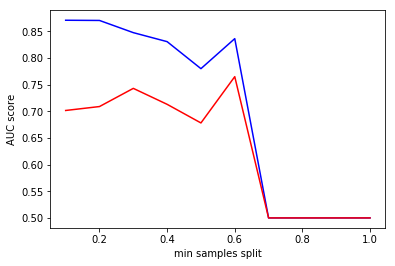

In [141]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    rf = RandomForestClassifier(min_samples_split=min_samples_split)
    rf.fit(x_train, y_train)
    train_pred = rf.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print ("********** Train **********")
    print (min_samples_split)
    print (roc_auc)
    train_results.append(roc_auc)
    y_pred = rf.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print ("Test")
    print (roc_auc)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
0.1
0.8465203554149265
Test
0.7570511874770057


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
0.2
0.8163781526518148
Test
0.7623462312055175


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
0.30000000000000004
0.7819588292647032
Test
0.7436137510901781


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
0.4
0.5
Test
0.5


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
0.5
0.5
Test
0.5


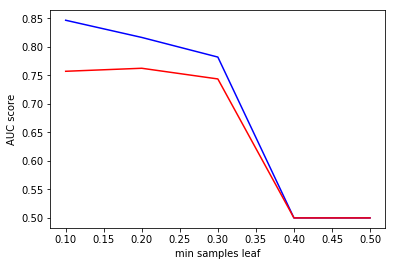

In [142]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf)
    rf.fit(x_train, y_train)
    train_pred = rf.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print ("********** Train **********")
    print (min_samples_leaf)
    print (roc_auc)
    train_results.append(roc_auc)
    y_pred = rf.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print ("Test")
    print (roc_auc)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
1
0.9992457550727569
Test
0.5942394712613196


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
2
0.9992089626372819
Test
0.5900634590998818


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
3
0.9992733493993636
Test
0.5878465925750238


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
4
0.9991353777663312
Test
0.5813892836666585


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
5
0.999190566419544
Test
0.5924091860688787


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
6
0.9992365569638882
Test
0.5987591112737948


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
7
0.9991629720929376
Test
0.587953976278473


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
8
0.9992365569638881
Test
0.5900205056185021


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
9
0.9992273588550193
Test
0.6009115475765833


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
10
0.9990893872219873
Test
0.5836276269322063


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
11
0.9991629720929377
Test
0.5923447558468092


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
12
0.9992273588550195
Test
0.5877392088715747


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
13
0.9991813683106753
Test
0.5855867725687863


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
14
0.999153773984069
Test
0.598866494977244


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
15
0.9992089626372818
Test
0.5899345986557428


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
16
0.9991445758752001
Test
0.5942824247426993


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
17
0.9992273588550195
Test
0.5835631967101368


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
18
0.9991905664195442
Test
0.589913121915053


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
19
0.9991445758752001
Test
0.5876747786495052


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
20
0.9990709910042496
Test
0.5877821623529544


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
21
0.9991721702018064
Test
0.5964348610454877


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
22
0.9991537739840688
Test
0.5855438190874067


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
23
0.9991261796574624
Test
0.596520768008247


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
24
0.9992089626372818
Test
0.5921085116992211


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
25
0.9993009437259699
Test
0.5922803256247396


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
26
0.999199764528413
Test
0.5943683317054586


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
27
0.9991721702018065
Test
0.5921514651806007


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
28
0.999043396677643
Test
0.5834558130066876


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
29
0.9991721702018064
Test
0.5898486916929835


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
30
0.9992825475082323
Test
0.5983725299413778


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
31
0.9992917456171012
Test
0.5964563377861776


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
32
0.9991813683106754
Test
0.5920226047364617


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
33
0.9991261796574624
Test
0.5942394712613196


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
34
0.9991537739840688
Test
0.5899775521371224


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
35
0.9992089626372819
Test
0.5831980921184097


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
36
0.9991905664195442
Test
0.5921729419212906


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
37
0.9991721702018066
Test
0.5812604232225196


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
38
0.9990893872219871
Test
0.5961771401572098


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
39
0.9991997645284129
Test
0.5941106108171806


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
40
0.9990433966776431
Test
0.5898486916929835


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
41
0.9991353777663312
Test
0.591850790810943


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
42
0.9991169815485936
Test
0.5895050638419461


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
43
0.9990617928953808
Test
0.5919366977737024


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
44
0.9992365569638884
Test
0.5918937442923228


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
45
0.999245755072757
Test
0.600417582540717


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
46
0.9990801891131182
Test
0.5942609480020095


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
47
0.9991077834397247
Test
0.5942824247426993


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
48
0.9990709910042496
Test
0.5942179945206298


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
49
0.9991813683106753
Test
0.5875244414646764


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
50
0.9991169815485937
Test
0.5959408960096216


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
51
0.999254953181626
Test
0.5940247038544213


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
52
0.9991629720929376
Test
0.5941535642985603


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
53
0.9990250004599055
Test
0.5879324995377833


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
54
0.9991169815485935
Test
0.5941535642985603


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
55
0.9990341985687743
Test
0.5941535642985603


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
56
0.9991813683106753
Test
0.5917434071074938


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
57
0.9990709910042496
Test
0.5877177321308849


C:\Users\Home\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********** Train **********
58
0.9990525947865119
Test
0.5873311507984679


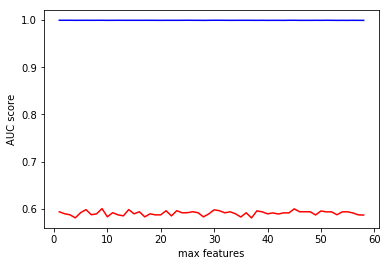

In [143]:
max_features = list(range(1,x_train.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
    rf = RandomForestClassifier(max_features=max_feature)
    rf.fit(x_train, y_train)
    train_pred = rf.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print ("********** Train **********")
    print (max_feature)
    print (roc_auc)
    train_results.append(roc_auc)
    y_pred = rf.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print ("Test")
    print (roc_auc)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()

In [147]:
# Tuned Features:
# n_estimators - 16
# max_depth - 4
# min_samples_split - 0.6
# min_samples_leaf - 0.2
# max_features - 9

rf = RandomForestClassifier(n_estimators = 16, max_depth = 4, min_samples_split = 0.6, min_samples_leaf = 0.2, max_features = 9)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

feature_list = list(trainRf.columns)
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];


from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print ("Feature Importance")
print (rf.feature_importances_)
print (roc_auc)
print (false_positive_rate)
print (true_positive_rate)




Variable: SUM(brand_Established) Importance: 0.31
Variable: itemCount            Importance: 0.12
Variable: SUM(category_Grocery) Importance: 0.12
Variable: sumItCouAvailUntilNow Importance: 0.12
Variable: family_size          Importance: 0.06
Variable: income_bracket       Importance: 0.06
Variable: Q2                   Importance: 0.06
Variable: couDiscAvaiCtDjSum   Importance: 0.06
Variable: couDiscAvaiCtFpSum   Importance: 0.06
Variable: age_range            Importance: 0.0
Variable: rented               Importance: 0.0
Variable: campaign_type        Importance: 0.0
Variable: SUM(brand_Local)     Importance: 0.0
Variable: SUM(category_Bakery) Importance: 0.0
Variable: SUM(category_DairyJuices) Importance: 0.0
Variable: SUM(category_FlowersPlants) Importance: 0.0
Variable: SUM(category_Garden) Importance: 0.0
Variable: SUM(category_Meat)   Importance: 0.0
Variable: SUM(category_Miscellaneous) Importance: 0.0
Variable: SUM(category_Natural_Products) Importance: 0.0
Variable: SUM(cate

In [164]:
# Actual model building for submission

Y = trainRf['redemption_status']
del trainRf['redemption_status']
X = trainRf
test_id = testRf['id']
del testRf['id']
X_test = testRf

from imblearn.over_sampling import SMOTE
smt = SMOTE()
x_train, y_train = smt.fit_sample(X, Y)

rf = RandomForestClassifier(n_estimators = 16, max_depth = 7, min_samples_split = 0.6, min_samples_leaf = 0.1, max_features = 12)
rf.fit(x_train, y_train)
redemption_status = rf.predict(X_test)

testRf['redemption_status'] = redemption_status
testRf['id'] = test_id
testRf.to_csv('submission17.csv')


In [91]:
del trainRf
del testRf
gc.collect()

9943

In [92]:
# Model building using XGBoost.
 
trainXG = trainAnalysis.copy(deep = True) 
testXG = testAnalysis.copy(deep = True)

In [93]:
# Marital status - Dosent affect target, many Nas, so ignore it
# No of children - Dosent affect target, many Nas, so ignore it

del trainXG['marital_status']
del trainXG['no_of_children']

# Mean Encoding categorical features.

ct_mean_encode = trainXG.groupby('campaign_type')['redemption_status'].mean()
trainXG.loc[:,'campaign_type'] = trainXG['campaign_type'].map(ct_mean_encode)

ib_mean_encode = trainXG.groupby('income_bracket')['redemption_status'].mean()
trainXG.loc[:,'income_bracket'] = trainXG['income_bracket'].map(ib_mean_encode)

rt_mean_encode = trainXG.groupby('rented')['redemption_status'].mean()
trainXG.loc[:,'rented'] = trainXG['rented'].map(rt_mean_encode)

ag_mean_encode = trainXG.groupby('age_range')['redemption_status'].mean()
trainXG.loc[:,'age_range'] = trainXG['age_range'].map(ag_mean_encode)

fs_mean_encode = trainXG.groupby('family_size')['redemption_status'].mean()
trainXG.loc[:,'family_size'] = trainXG['family_size'].map(fs_mean_encode)

del trainXG['campaign_id']
del trainXG['coupon_id']
del trainXG['customer_id']
del trainXG['start_date']
del trainXG['end_date']


In [94]:
# Doing Everything for test data as well.

del testXG['marital_status']
del testXG['no_of_children']

testXG.loc[:,'campaign_type'] = testXG['campaign_type'].map(ct_mean_encode)
testXG.loc[:,'income_bracket'] = testXG['income_bracket'].map(ib_mean_encode)
testXG.loc[:,'rented'] = testXG['rented'].map(rt_mean_encode)
testXG.loc[:,'age_range'] = testXG['age_range'].map(ag_mean_encode)
testXG.loc[:,'family_size'] = testXG['family_size'].map(fs_mean_encode)

del testXG['campaign_id']
del testXG['coupon_id']
del testXG['customer_id']
del testXG['start_date']
del testXG['end_date']

In [95]:
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import train_test_split

Y = trainXG['redemption_status']
del trainXG['redemption_status']
X = trainXG

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

# Generally, the Scale_pos_weight is the ratio of number of negative class to the positive class. so here it is 77640/729
xg = xgb.XGBClassifier(objective = 'reg:logistic', scale_pos_weight = 106.50)
xg.fit(x_train, y_train)
y_pred_train = xg.predict(x_train)
y_pred_test = xg.predict(x_test)

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_pred_train)
roc_auc = auc(false_positive_rate, true_positive_rate)
print (roc_auc)
print (false_positive_rate)
print (true_positive_rate)

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print (roc_auc)
print (false_positive_rate)
print (true_positive_rate)




0.8492670692476768
[0.         0.15717728 1.        ]
[0.         0.85571142 1.        ]
0.8020923948059904
[0.        0.1610326 1.       ]
[0.         0.76521739 1.        ]


In [373]:
# Actual model building for submission

import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import train_test_split

Y = trainXG['redemption_status']
del trainXG['redemption_status']
X = trainXG
test_id = testXG['id']
del testXG['id']
X_test = testXG

xg = xgb.XGBClassifier(objective = 'reg:logistic', scale_pos_weight = 106.50)
xg.fit(X, Y)
redemption_status = xg.predict(X_test)
testXG['redemption_status'] = redemption_status
testXG['id'] = test_id
testXG.to_csv('submission12.csv')

In [375]:
del trainXG
del testXG
gc.collect()

476